In [ ]:
!pip install -q transformers accelerate datasets scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.7 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

dataset = load_dataset("codelion/Qwen3-0.6B-pts", split="train")

print("Number of examples:", len(dataset))
print("Keys:", dataset.column_names)
print("First example:\n", dataset[0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

gsm8k_pivotal_tokens.jsonl: 0.00B [00:00, ?B/s]

pivotal_tokens.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/1376 [00:00<?, ? examples/s]

Number of examples: 1376
Keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
First example:
 {'model_id': 'Qwen/Qwen3-0.6B', 'query': 'Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?', 'pivot_context': 'Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn? \n\n', 'pivot_token': 'A', 'pivot_token_id': 32, 'prob_before': 0.68, 'prob_after': 0.0, 'prob_delta': -0.68, 'is_positive': False, 'task_type': 'generic', 'dataset_id': 'openai/gsm8k', 'dataset_item_id': '1', 'timestamp': datetime.datetime(2025, 5, 13, 14, 0, 26)}


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "Qwen/Qwen3-0.6B"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    output_hidden_states=True,  # Important: to get layer activations
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
).to(device)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
def get_last_hidden_state(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.hidden_states[-1][0, -1, :].cpu().numpy()

In [ ]:
import numpy as np

features = []
labels = []

for example in dataset.select(range(200)):
    context = example["pivot_context"]
    label = 1 if example["is_positive"] else 0

    vec = get_last_hidden_state(context)
    features.append(vec)
    labels.append(label)

X = np.stack(features)
y = np.array(labels)

print("Feature matrix shape:", X.shape)
print("Label shape:", y.shape)

Feature matrix shape: (200, 1024)
Label shape: (200,)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

clf = LogisticRegression(max_iter=2000)
scores = cross_val_score(clf, X, y, cv=5, scoring="accuracy")

print("5-fold cross-validation accuracy:", scores.mean())

5-fold cross-validation accuracy: 0.72


Processing layer 0...
Layer 0 accuracy: 0.680
Processing layer 1...
Layer 1 accuracy: 0.673
Processing layer 2...
Layer 2 accuracy: 0.707
Processing layer 3...
Layer 3 accuracy: 0.707
Processing layer 4...
Layer 4 accuracy: 0.713
Processing layer 5...
Layer 5 accuracy: 0.760
Processing layer 6...
Layer 6 accuracy: 0.713
Processing layer 7...
Layer 7 accuracy: 0.740
Processing layer 8...
Layer 8 accuracy: 0.700
Processing layer 9...
Layer 9 accuracy: 0.707
Processing layer 10...
Layer 10 accuracy: 0.727
Processing layer 11...
Layer 11 accuracy: 0.673
Processing layer 12...
Layer 12 accuracy: 0.673
Processing layer 13...
Layer 13 accuracy: 0.680
Processing layer 14...
Layer 14 accuracy: 0.667
Processing layer 15...
Layer 15 accuracy: 0.653
Processing layer 16...
Layer 16 accuracy: 0.667
Processing layer 17...
Layer 17 accuracy: 0.693
Processing layer 18...
Layer 18 accuracy: 0.667
Processing layer 19...
Layer 19 accuracy: 0.640
Processing layer 20...
Layer 20 accuracy: 0.673
Processing l

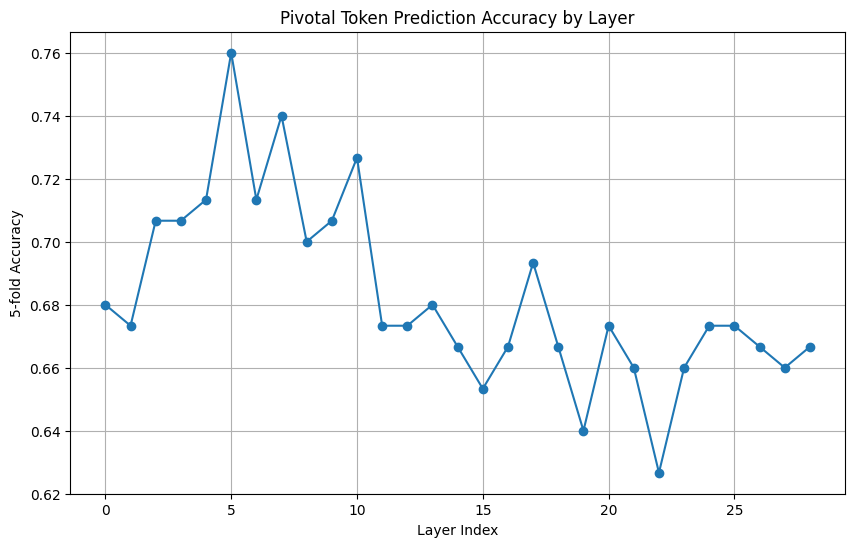

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Limit to 150 examples to keep it fast
subset = dataset.select(range(150))
print("Running analysis on", len(subset), "examples")

all_layer_scores = []
num_layers = model.config.num_hidden_layers

# We'll process one layer at a time
num_layers = model.config.num_hidden_layers

for layer_idx in range(num_layers + 1):  # +1 because hidden_states[0] is embeddings
    print(f"Processing layer {layer_idx}...")
    layer_features = []
    labels = []

    for example in subset:
        context = example["pivot_context"]
        label = 1 if example["is_positive"] else 0

        # Get all hidden states
        inputs = tokenizer(context, return_tensors="pt", truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states = outputs.hidden_states

        vec = hidden_states[layer_idx][0, -1, :].cpu().numpy()
        layer_features.append(vec)
        labels.append(label)

    X = np.stack(layer_features)
    y = np.array(labels)

    clf = LogisticRegression(max_iter=2000)
    scores = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
    acc = scores.mean()
    print(f"Layer {layer_idx} accuracy: {acc:.3f}")
    all_layer_scores.append(acc)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(num_layers + 1), all_layer_scores, marker="o")
plt.xlabel("Layer Index")
plt.ylabel("5-fold Accuracy")
plt.title("Pivotal Token Prediction Accuracy by Layer")
plt.grid(True)

# Save first, then show
plt.savefig("layer_probe_plot_150_examples.png")
plt.show()

In [ ]:
import pandas as pd

# Save scores to a CSV file
df = pd.DataFrame({
    "layer": list(range(len(all_layer_scores))),
    "accuracy": all_layer_scores
})
df.to_csv("layer_probe_results_150_examples.csv", index=False)
print("Saved: layer_probe_results_150_examples.csv")

Saved: layer_probe_results_150_examples.csv


In [ ]:
plt.savefig("layer_probe_plot_150_examples.png")
print("Saved: layer_probe_plot_150_examples.png")

Saved: layer_probe_plot_150_examples.png


<Figure size 640x480 with 0 Axes>

In [ ]:
from google.colab import files
files.download("layer_probe_results_150_examples.csv")
files.download("layer_probe_plot_150_examples.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running analysis on 1376 examples
Processing layer 0...
Layer 0 accuracy: 0.591
Processing layer 1...
Layer 1 accuracy: 0.619
Processing layer 2...
Layer 2 accuracy: 0.608
Processing layer 3...
Layer 3 accuracy: 0.624
Processing layer 4...
Layer 4 accuracy: 0.610
Processing layer 5...
Layer 5 accuracy: 0.637
Processing layer 6...
Layer 6 accuracy: 0.617
Processing layer 7...
Layer 7 accuracy: 0.613
Processing layer 8...
Layer 8 accuracy: 0.612
Processing layer 9...
Layer 9 accuracy: 0.581
Processing layer 10...
Layer 10 accuracy: 0.598
Processing layer 11...
Layer 11 accuracy: 0.619
Processing layer 12...
Layer 12 accuracy: 0.610
Processing layer 13...
Layer 13 accuracy: 0.602
Processing layer 14...
Layer 14 accuracy: 0.588
Processing layer 15...
Layer 15 accuracy: 0.591
Processing layer 16...
Layer 16 accuracy: 0.615
Processing layer 17...
Layer 17 accuracy: 0.598
Processing layer 18...
Layer 18 accuracy: 0.597
Processing layer 19...
Layer 19 accuracy: 0.601
Processing layer 20...
Lay

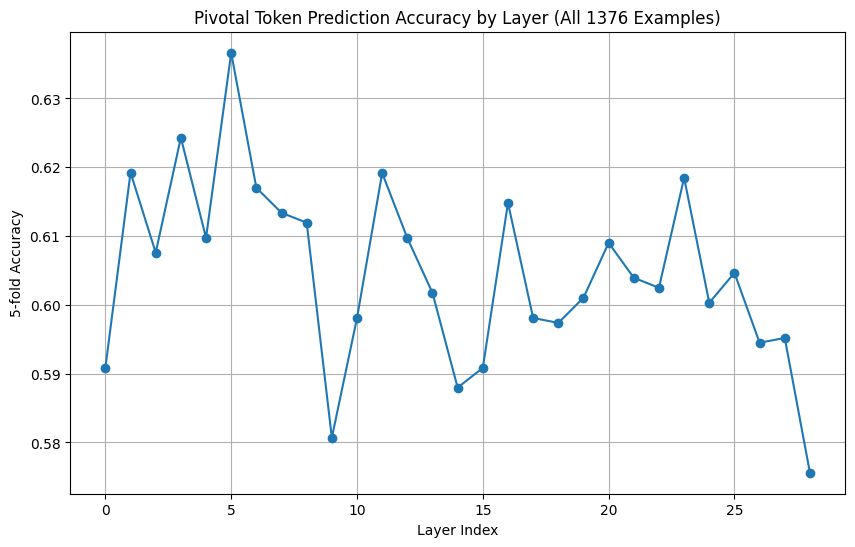

Saved: layer_probe_plot_all_examples.png


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Use the full dataset (all 1376 examples)
subset = dataset
print("Running analysis on", len(subset), "examples")

all_layer_scores = []
num_layers = model.config.num_hidden_layers

# Process one layer at a time
for layer_idx in range(num_layers + 1):  # +1 because hidden_states[0] is embeddings
    print(f"Processing layer {layer_idx}...")
    layer_features = []
    labels = []

    for example in subset:
        context = example["pivot_context"]
        label = 1 if example["is_positive"] else 0

        # Get hidden states
        inputs = tokenizer(context, return_tensors="pt", truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states = outputs.hidden_states

        vec = hidden_states[layer_idx][0, -1, :].cpu().numpy()
        layer_features.append(vec)
        labels.append(label)

    X = np.stack(layer_features)
    y = np.array(labels)

    clf = LogisticRegression(max_iter=2000)
    scores = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
    acc = scores.mean()
    print(f"Layer {layer_idx} accuracy: {acc:.3f}")
    all_layer_scores.append(acc)

# Save results to CSV
df = pd.DataFrame({
    "layer": list(range(len(all_layer_scores))),
    "accuracy": all_layer_scores
})
df.to_csv("layer_probe_results_all_examples.csv", index=False)
print("Saved: layer_probe_results_all_examples.csv")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(num_layers + 1), all_layer_scores, marker="o")
plt.xlabel("Layer Index")
plt.ylabel("5-fold Accuracy")
plt.title("Pivotal Token Prediction Accuracy by Layer (All 1376 Examples)")
plt.grid(True)

# Save first, then show
plt.savefig("layer_probe_plot_all_examples.png")
plt.show()

print("Saved: layer_probe_plot_all_examples.png")

In [ ]:
from google.colab import files
files.download("layer_probe_results_all_examples.csv")
files.download("layer_probe_plot_all_examples.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>